In [1]:
import numpy as np             
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from keras.applications.resnet import ResNet50
from tensorflow.keras import layers
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

from keras.applications.vgg16 import VGG16

In [2]:
from tensorflow.keras.applications.resnet50 import ResNet50
Resnet_model = ResNet50(weights='imagenet', include_top=False)

In [3]:
result = Resnet_model.output
result = GlobalAveragePooling2D()(result)
# add a fully-connected layer
result = Dense(512, activation='relu')(result)
# and a fully connected output/classification layer
predictions = Dense(2, activation='sigmoid')(result)

In [4]:
inception_transfer =Model(inputs=Resnet_model.input, outputs=predictions)

In [5]:
inception_transfer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                           

In [6]:
from tensorflow.keras.optimizers import SGD
inception_transfer.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['accuracy'])

In [7]:
from keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_path = 'C:/Users/Computing/Desktop/lukman/train'
test_path = 'C:/Users/Computing/Desktop/lukman/test'
valid_path = 'C:/Users/Computing/Desktop/lukman/val'

test_datagen = ImageDataGenerator(rescale=1. / 255)
val_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical')

Found 3000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [8]:
import tensorflow as tf
with tf.device("/device:GPU:0"):
    history_pretrained = inception_transfer.fit_generator(
    train_generator,
    epochs=15, shuffle = True, verbose = 1, validation_data = test_generator)

<ipython-input-8-b607d3519ffa>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_pretrained = inception_transfer.fit_generator(


Epoch 1/15
188/188 [==============================] - 452s 2s/step - loss: 0.4642 - accuracy: 0.7833 - val_loss: 0.5168 - val_accuracy: 0.7900
Epoch 2/15
188/188 [==============================] - 1003s 5s/step - loss: 0.4223 - accuracy: 0.8040 - val_loss: 0.5890 - val_accuracy: 0.7900
Epoch 3/15
188/188 [==============================] - 1185s 6s/step - loss: 0.3956 - accuracy: 0.8177 - val_loss: 0.5604 - val_accuracy: 0.7880
Epoch 4/15
188/188 [==============================] - 1165s 6s/step - loss: 0.3871 - accuracy: 0.8263 - val_loss: 0.5166 - val_accuracy: 0.7900
Epoch 5/15
188/188 [==============================] - 1202s 6s/step - loss: 0.3807 - accuracy: 0.8290 - val_loss: 0.4609 - val_accuracy: 0.7920
Epoch 6/15
188/188 [==============================] - 1144s 6s/step - loss: 0.3717 - accuracy: 0.8380 - val_loss: 0.4517 - val_accuracy: 0.7960
Epoch 7/15
188/188 [==============================] - 1058s 6s/step - loss: 0.3643 - accuracy: 0.8397 - val_loss: 0.4330 - val_accuracy: 

<AxesSubplot:>

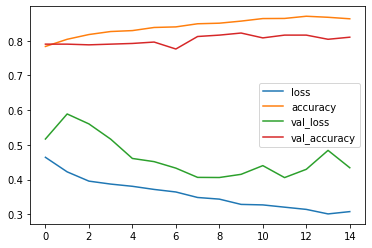

In [9]:
pd.DataFrame( inception_transfer.history.history).plot()

In [10]:
scores = inception_transfer.evaluate(test_generator)
print('acc =',scores[1]*100)

32/32 [==============================] - 15s 454ms/step - loss: 0.4341 - accuracy: 0.8100
acc = 81.00000023841858


In [11]:
preds =  inception_transfer.predict(test_generator,verbose=1)

32/32 [==============================] - 15s 457ms/step


# CONFUSION MATRIX PLOT

32/32 [==============================] - 15s 472ms/step
Confusion Matrix
[[311  79]
 [ 87  23]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.78      0.80      0.79       390
   PNEUMONIA       0.23      0.21      0.22       110

    accuracy                           0.67       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.66      0.67      0.66       500



[Text(0, 0.5, 'Pneumonia'), Text(0, 1.5, 'no_pneumonia')]

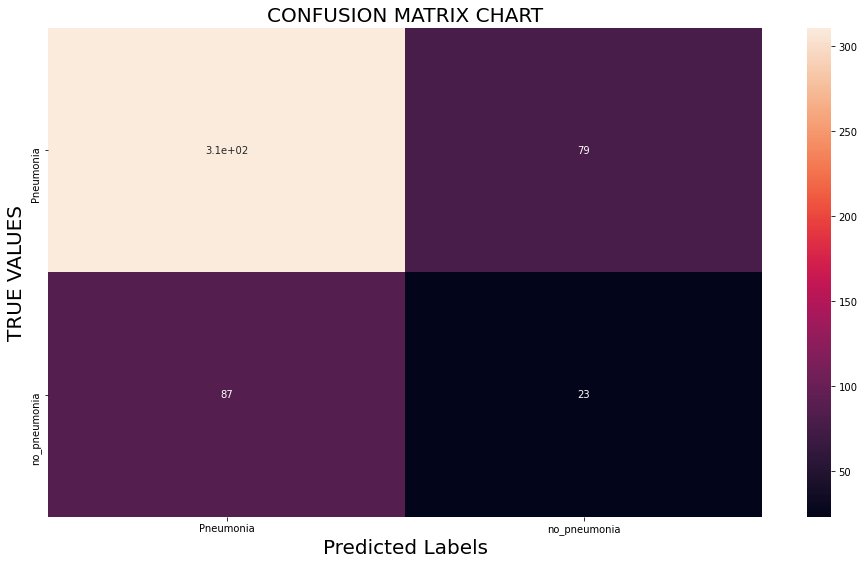

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns 
batch_size=64
Y_pred = inception_transfer.predict(test_generator,verbose=1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL','PNEUMONIA']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

matrix = confusion_matrix(validation_generator.classes, y_pred)
labels=(( 'Pneumonia'),('no_pneumonia'))
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)


# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('TRUE VALUES', size=20)
ax.set_title('CONFUSION MATRIX CHART', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

In [21]:
matrix = confusion_matrix(validation_generator.classes, y_pred)

matrix

print('='*50)                                
print('True Positive  (TP) = ', matrix[0][0])
print('False Positive (FP) = ', matrix[0][1])
print('False Negative (FN) = ', matrix[1][0])
print('True Negative  (TN) = ', matrix[1][1])



True Positive  (TP) =  311
False Positive (FP) =  79
False Negative (FN) =  87
True Negative  (TN) =  23


(500, 224, 224, 3)
(500, 2)


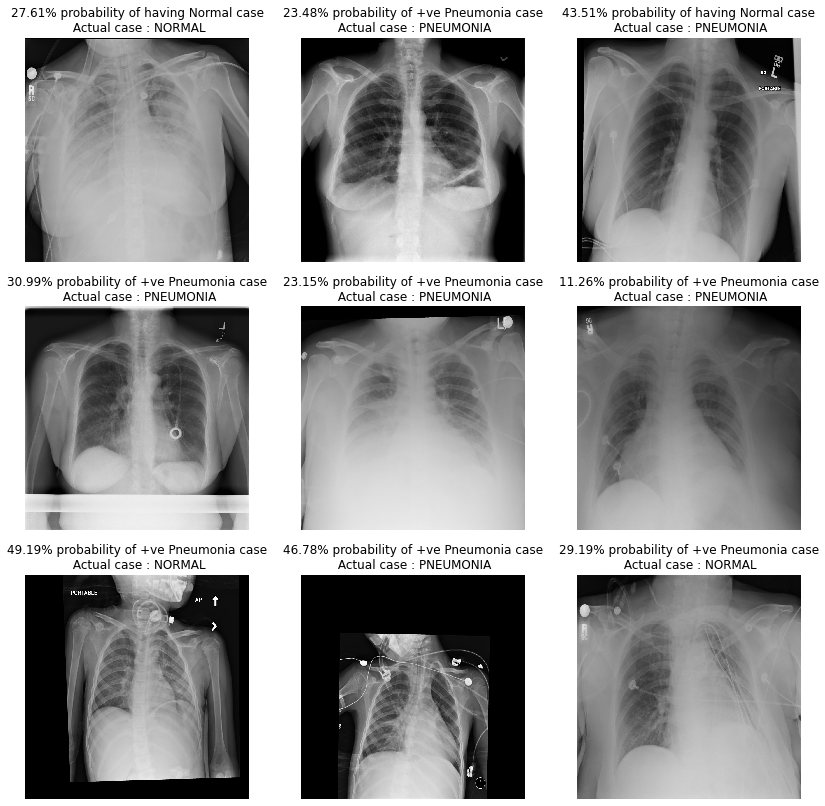

In [20]:
test_generator.reset()
x=np.concatenate([test_generator.next()[0] for i in range(test_generator.__len__())])
y=np.concatenate([test_generator.next()[1] for i in range(test_generator.__len__())])
print(x.shape)
print(y.shape)

dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(14, 14))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of +ve Pneumonia case'.format(preds[i][1]))    
  else: 
      out = ('{:.2%} probability of having Normal case'.format(1-preds[i][1]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i][0]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()